In [ ]:
"""
Aircraft Flap Water Ingression Predictive Analytics
==================================================
Predicting water ingression in aircraft trailing edge flap components using machine learning.
Target: 68% recall achieved with Optimized Logistic Regression for safety-critical application.
Dataset: 503 multi-modal NDT inspection records (35% water ingression rate)
Method: SMOTE + threshold optimization with advanced feature engineering and risk assessment
Key Features: 3NF database design, physics-based metrics, temporal analysis, SHAP interpretability
"""

In [1]:
## Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, recall_score, roc_auc_score,  f1_score, precision_score, roc_curve
from imblearn.over_sampling import SMOTE
import shap

In [ ]:
## Read csv file
df = pd.read_csv(r"\Prepped Data.csv")

In [3]:
## Correlation Analysis Function
def phi_coefficient(x, y):
    crosstab = pd.crosstab(x, y)
    chi2, p_value, dof, expected = chi2_contingency(crosstab)
    n = len(x)
    phi = np.sqrt(chi2 / n)
    return phi, p_value

def cramers_v(x, y):
    crosstab = pd.crosstab(x, y)
    chi2, p_value, dof, expected = chi2_contingency(crosstab)
    n = crosstab.sum().sum()
    cramers_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
    return cramers_v, p_value

def pointbiserial_correlation(cont_var, binary_var):
    correlation, p_value = pointbiserialr(binary_var, cont_var)
    return correlation, p_value

In [4]:
## Correlation Analysis
# Phi Coefficient (binary vs binary)
print("\nDISBOND vs WATER")
phi_disbond_water, p_disbond_water = phi_coefficient(df['Disbond'],df['Water'])
print(f"Phi Coefficient: {phi_disbond_water:.3f}")
print(f"P-value: {p_disbond_water:.3f}")

# Cramér's V (nominal categorical vs binary)
print("\nRAIN_SEASON vs WATER")
cramers_rain_water, p_rain_water = cramers_v(df['Rain_Season'], df['Water'])
print(f"Cramér's V: {cramers_rain_water:.3f}")
print(f"P-value: {p_rain_water:.3f}")

# Phi Coefficient (binary vs binary)
print("\nPOSITION vs WATER")
phi_position_water, p_position_water = phi_coefficient(df['Position'], df['Water'])
print(f"Phi Coefficient: {phi_position_water:.3f}")
print(f"P-value: {p_position_water:.3f}")

# Cramér's V (nominal categorical vs binary)
print("\nPN vs WATER")
cramers_pn_water, p_pn_water = cramers_v(df['PN'], df['Water'])
print(f"Cramér's V: {cramers_pn_water:.3f}")
print(f"P-value: {p_pn_water:.3f}")

# Point-biserial (continuous vs binary)
print("\nEXPOSURE vs WATER")
pb_exposure_water, p_exposure_water = pointbiserial_correlation(df['Exposure'], df['Water'])
print(f"Point-biserial correlation: {pb_exposure_water:.3f}")
print(f"P-value: {p_exposure_water:.3f}")



DISBOND vs WATER
Phi Coefficient: 0.002
P-value: 0.965

RAIN_SEASON vs WATER
Cramér's V: 0.046
P-value: 0.582

POSITION vs WATER
Phi Coefficient: 0.050
P-value: 0.265

PN vs WATER
Cramér's V: 0.215
P-value: 0.025

EXPOSURE vs WATER
Point-biserial correlation: -0.090
P-value: 0.044


In [5]:
## Data Preprocessing
# Prepare features and target
df_ml = df.drop(columns=["Inspection ID", "Position", "Disbond"])
X = df_ml.drop(columns="Water")
y = df_ml["Water"]

# Define feature types
numeric_features = ["mAm", "SFD", "Exposure", "Relative Day"]
categorical_features = ["PN", "Rain_Season", "Film_Type(D4=0,D7=1)"]

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [6]:
## Defining Functions
# Model evaluation function
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Evaluation:")
    print(classification_report(y_true, y_pred))
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall: {recall_score(y_true, y_pred):.3f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_true, y_pred):.3f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Confusion matrix Function
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# ROC curve function
def plot_roc(y_true, y_score, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_true, y_score):.2f})')
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()


Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       0.75      0.59      0.66        66
           1       0.45      0.63      0.52        35

    accuracy                           0.60       101
   macro avg       0.60      0.61      0.59       101
weighted avg       0.65      0.60      0.61       101

Precision: 0.449
Recall: 0.629
F1 Score: 0.524
ROC AUC: 0.610

Confusion Matrix:
 [[39 27]
 [13 22]]

Random Forest Evaluation:
              precision    recall  f1-score   support

           0       0.69      0.65      0.67        66
           1       0.41      0.46      0.43        35

    accuracy                           0.58       101
   macro avg       0.55      0.55      0.55       101
weighted avg       0.60      0.58      0.59       101

Precision: 0.410
Recall: 0.457
F1 Score: 0.432
ROC AUC: 0.554

Confusion Matrix:
 [[43 23]
 [19 16]]

XGBoost Evaluation:
              precision    recall  f1-score   support

        

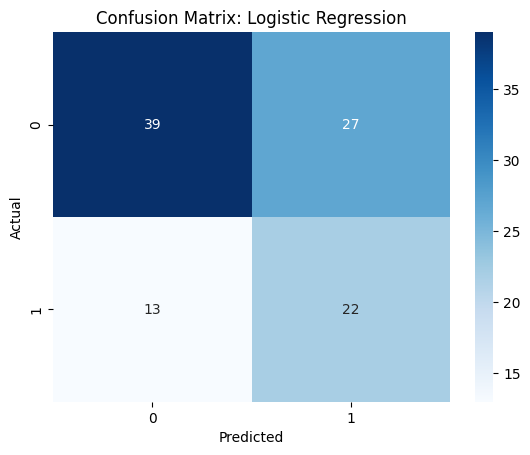

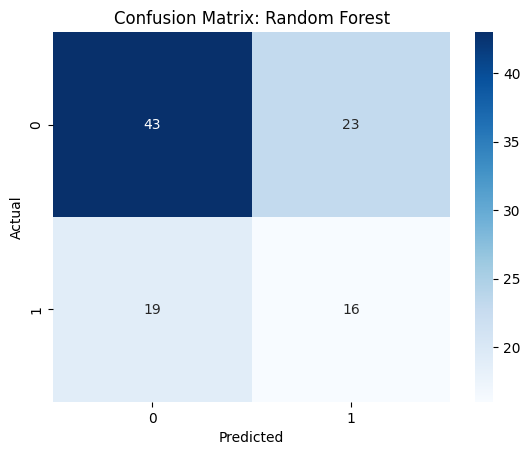

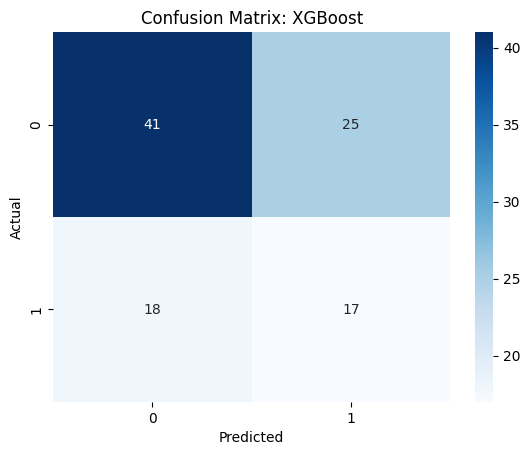

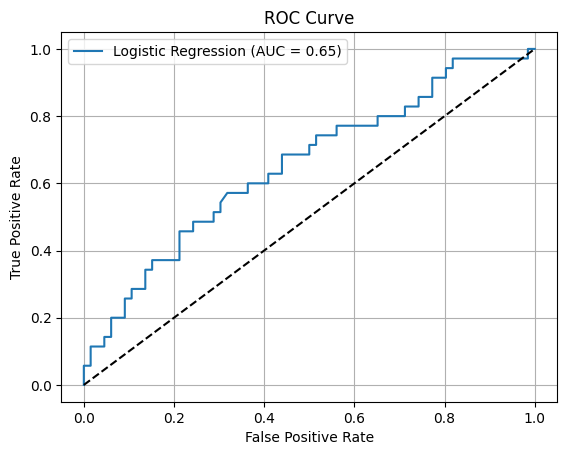

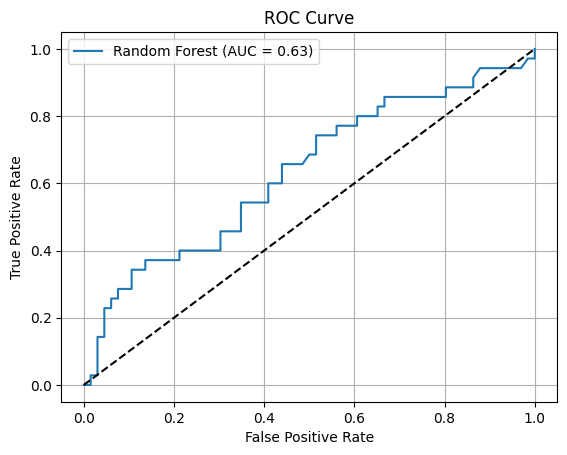

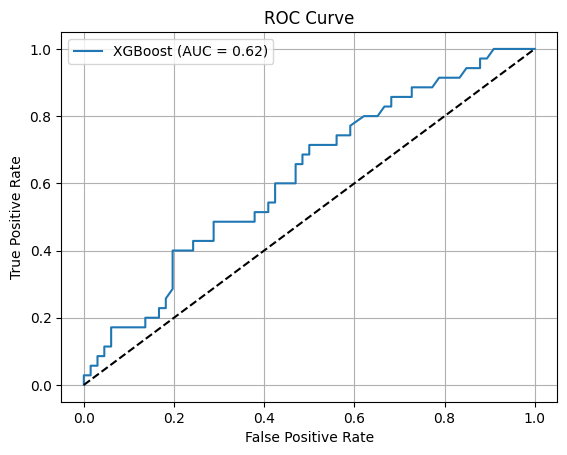

In [7]:
## Baseline Models
logreg = LogisticRegression(random_state=42, class_weight="balanced")
rf = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=2, class_weight='balanced', random_state=42)
xgb = XGBClassifier(scale_pos_weight=1.86, max_depth=6, learning_rate=0.1, n_estimators=200, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42)
# 65.21/34.79 ≈ 1.86 from class imbalance
logreg.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Evaluate baseline models
evaluate_model(y_test, logreg.predict(X_test), "Logistic Regression")
evaluate_model(y_test, rf.predict(X_test), "Random Forest")
evaluate_model(y_test, xgb.predict(X_test), "XGBoost")

plot_conf_matrix(y_test, logreg.predict(X_test), 'Logistic Regression')
plot_conf_matrix(y_test, rf.predict(X_test), 'Random Forest')
plot_conf_matrix(y_test, xgb.predict(X_test), 'XGBoost')

plot_roc(y_test, logreg.predict_proba(X_test)[:,1], 'Logistic Regression')
plot_roc(y_test, rf.predict_proba(X_test)[:,1], 'Random Forest')
plot_roc(y_test, xgb.predict_proba(X_test)[:,1], 'XGBoost')


Logistic Regression (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       0.71      0.52      0.60        66
           1       0.40      0.60      0.48        35

    accuracy                           0.54       101
   macro avg       0.55      0.56      0.54       101
weighted avg       0.60      0.54      0.56       101

Precision: 0.396
Recall: 0.600
F1 Score: 0.477
ROC AUC: 0.558

Confusion Matrix:
 [[34 32]
 [14 21]]

Random Forest (SMOTE) Evaluation:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        66
           1       0.44      0.51      0.47        35

    accuracy                           0.60       101
   macro avg       0.58      0.58      0.58       101
weighted avg       0.62      0.60      0.61       101

Precision: 0.439
Recall: 0.514
F1 Score: 0.474
ROC AUC: 0.583

Confusion Matrix:
 [[43 23]
 [17 18]]

XGBoost (SMOTE) Evaluation:
              precision    recall  f1-s

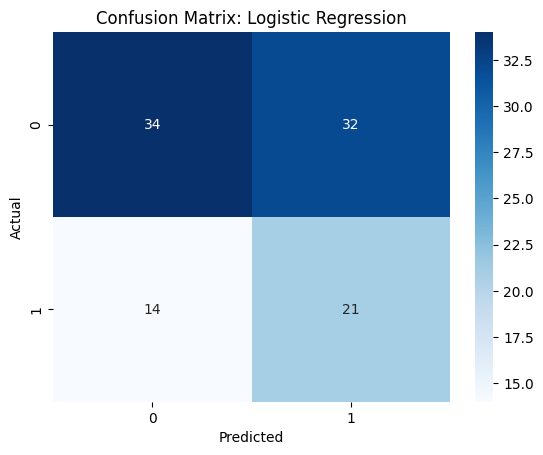

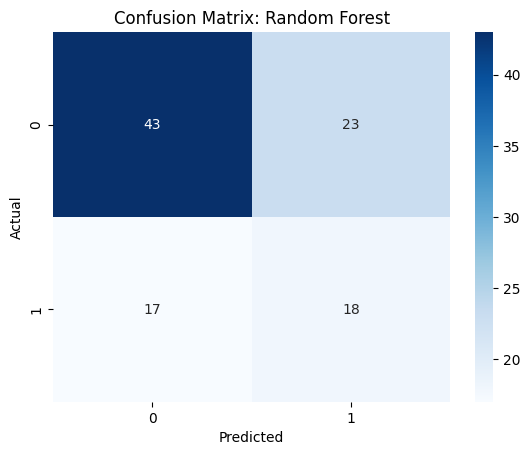

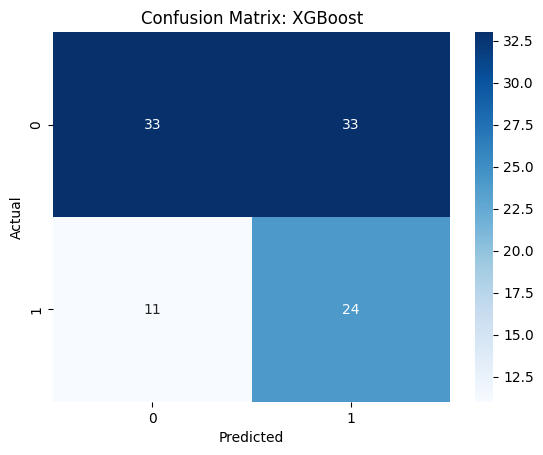

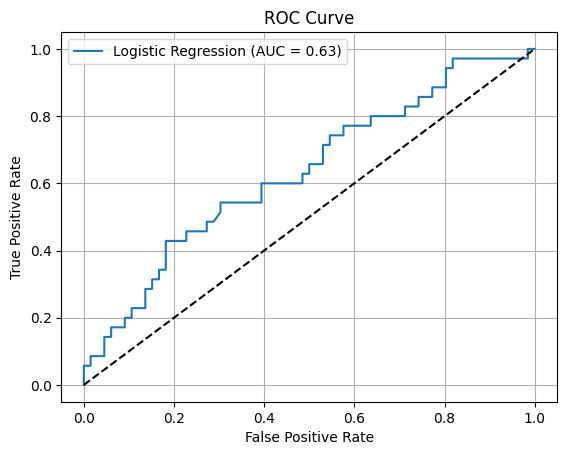

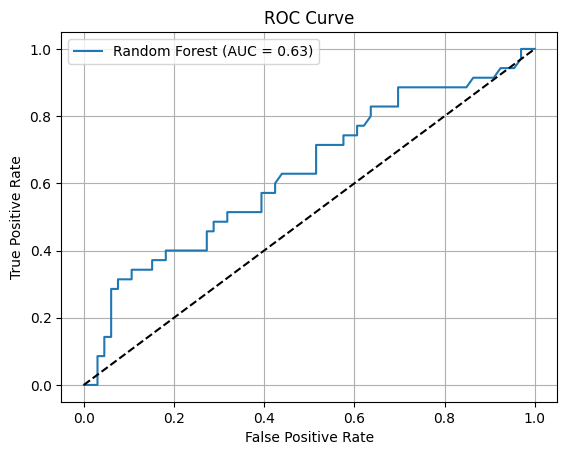

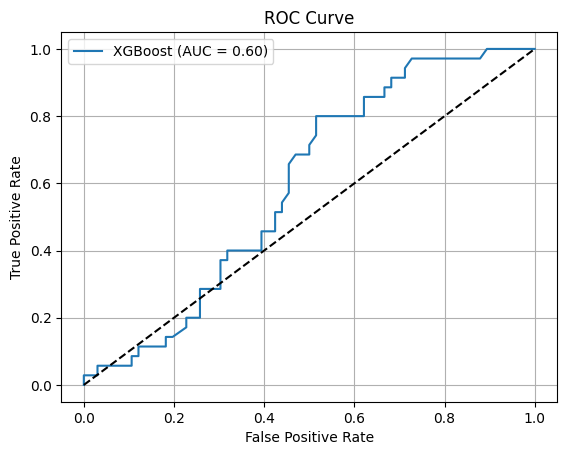

In [8]:
## SMOTE Implementation
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
logreg_smote = LogisticRegression(random_state=42)
rf_smote = RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=2, random_state=42)
xgb_smote = XGBClassifier(scale_pos_weight=1.86, max_depth=6, learning_rate=0.1, n_estimators=200, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42)

logreg_smote.fit(X_train_smote, y_train_smote)
rf_smote.fit(X_train_smote, y_train_smote)
xgb_smote.fit(X_train_smote, y_train_smote)

# Evaluate SMOTE models
evaluate_model(y_test, logreg_smote.predict(X_test), "Logistic Regression (SMOTE)")
evaluate_model(y_test, rf_smote.predict(X_test), "Random Forest (SMOTE)")
evaluate_model(y_test, xgb_smote.predict(X_test), "XGBoost (SMOTE)")

plot_conf_matrix(y_test, logreg_smote.predict(X_test), 'Logistic Regression')
plot_conf_matrix(y_test, rf_smote.predict(X_test), 'Random Forest')
plot_conf_matrix(y_test, xgb_smote.predict(X_test), 'XGBoost')

plot_roc(y_test, logreg_smote.predict_proba(X_test)[:,1], 'Logistic Regression')
plot_roc(y_test, rf_smote.predict_proba(X_test)[:,1], 'Random Forest')
plot_roc(y_test, xgb_smote.predict_proba(X_test)[:,1], 'XGBoost')


Top 10 Important Features:
                   Feature  Importance
3             Relative Day    0.474906
4                  PN_PN02    0.060837
2                 Exposure    0.049286
0                      mAm    0.048298
16          Rain_Season_SE    0.044617
17  Rain_Season_Transition    0.044393
6                  PN_PN04    0.039302
7                  PN_PN05    0.034833
11                 PN_PN09    0.034548
5                  PN_PN03    0.026774


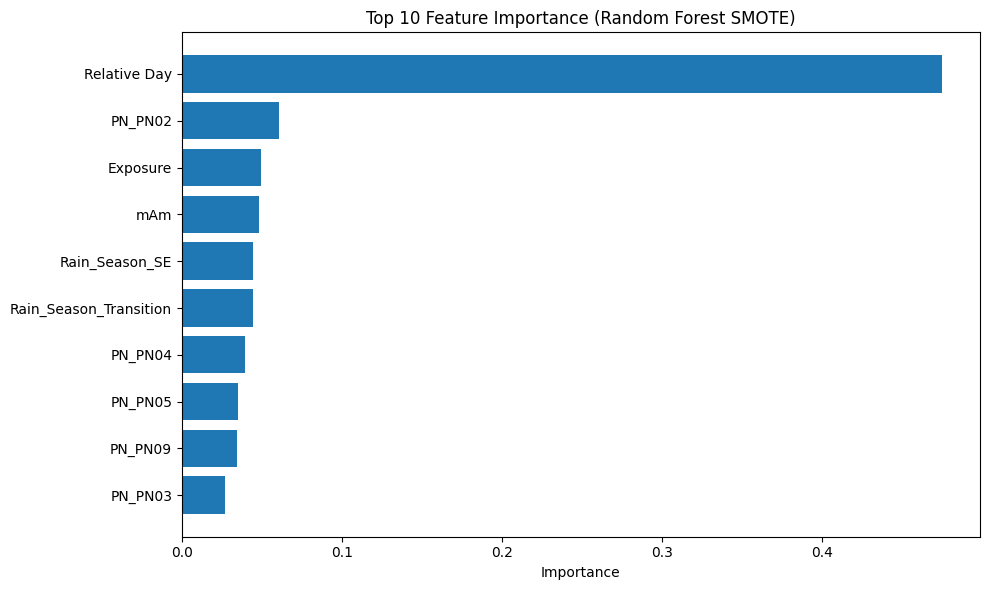

In [9]:
## Feature Importance
# Get feature names after preprocessing
feature_names = (numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)))

# Random Forest feature importance
rf_importance = rf_smote.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importance}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df.head(10)['Feature'], importance_df.head(10)['Importance'])
plt.title('Top 10 Feature Importance (Random Forest SMOTE)')
plt.xlabel('Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Best threshold: 0.40
Best F1 score: 0.530


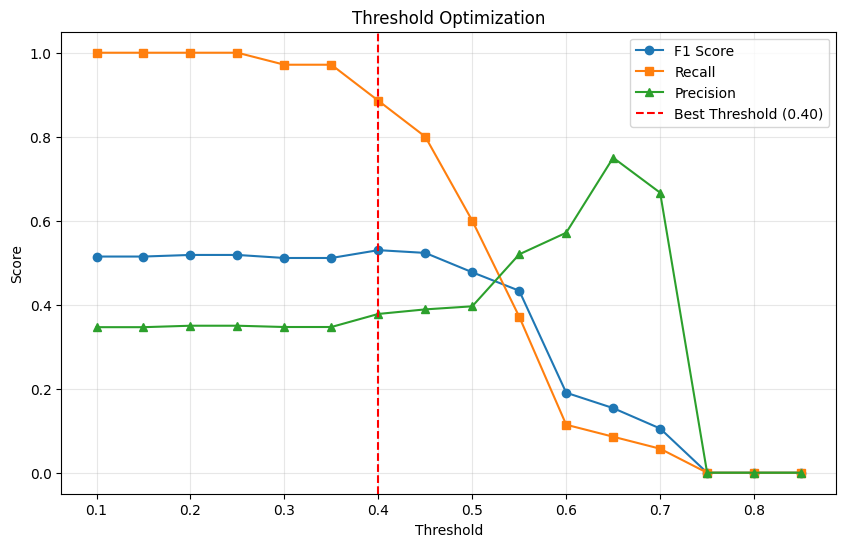


Final Model (Optimized Threshold) Evaluation:
              precision    recall  f1-score   support

           0       0.79      0.23      0.35        66
           1       0.38      0.89      0.53        35

    accuracy                           0.46       101
   macro avg       0.58      0.56      0.44       101
weighted avg       0.65      0.46      0.41       101

Precision: 0.378
Recall: 0.886
F1 Score: 0.530
ROC AUC: 0.556

Confusion Matrix:
 [[15 51]
 [ 4 31]]


In [10]:
## Threshold Optimization
# Probabilities from best model (Logistic Regression SMOTE)
y_proba = logreg_smote.predict_proba(X_test)[:, 1] # Class 1 = Water Ingress

# Test different thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []
recall_scores = []
precision_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_proba >= threshold).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))
    recall_scores.append(recall_score(y_test, y_pred_thresh))
    precision_scores.append(precision_score(y_test, y_pred_thresh))

# Find best threshold (max F1)
best_f1_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_idx]
best_f1 = f1_scores[best_f1_idx]

print(f"\nBest threshold: {best_threshold:.2f}")
print(f"Best F1 score: {best_f1:.3f}")

# Plot threshold analysis
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', marker='o')
plt.plot(thresholds, recall_scores, label='Recall', marker='s')
plt.plot(thresholds, precision_scores, label='Precision', marker='^')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Optimization')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Apply best threshold (Final Model)
y_pred_final = (y_proba >= best_threshold).astype(int)
evaluate_model(y_test, y_pred_final, "Final Model (Optimized Threshold)")

In [11]:
## Coefficient for Risk Assessment
# Logistic Regression SMOTE coefficients
coefficients = logreg_smote.coef_[0]
coef_df = pd.DataFrame({'Feature': feature_names,'Coefficient': coefficients,'Abs_Coefficient': np.abs(coefficients)}).sort_values('Abs_Coefficient', ascending=False)

print("Top 10 Most Influential Features (Logistic Regression SMOTE):")
print(coef_df.head(10)[['Feature', 'Coefficient']])

Top 10 Most Influential Features (Logistic Regression SMOTE):
    Feature  Coefficient
15  PN_PN13    -1.230122
8   PN_PN06    -0.996503
11  PN_PN09     0.919695
13  PN_PN11     0.819091
12  PN_PN10     0.501689
14  PN_PN12     0.430117
9   PN_PN07    -0.399571
7   PN_PN05    -0.376049
10  PN_PN08     0.275903
0       mAm    -0.244907


In [12]:
## Risk Assessment
def assess_component_risk(pn, relative_day):
    """Assess component risk based on PN and age"""
    # Age risk assessment
    if relative_day > 2000:
        age_risk, age_multiplier = "HIGH", 2.0
    elif relative_day > 1000:
        age_risk, age_multiplier = "MEDIUM", 1.5
    else:
        age_risk, age_multiplier = "LOW", 1.0
    
    # PN risk mapping (based on coefficient)
    pn_risk_map = {
        'PN09': ('CRITICAL', 2.5),
        'PN08': ('HIGH', 2.0),
        'PN04': ('HIGH', 1.8),
        'PN11': ('HIGH', 1.8),
        'PN12': ('MEDIUM', 1.2),
        'PN10': ('MEDIUM', 1.2),
        'PN02': ('MEDIUM', 1.1),
        'PN01': ('MEDIUM', 1.0), # Baseline
        'PN07': ('LOW', 0.8),
        'PN05': ('LOW', 0.7),
        'PN06': ('LOW', 0.6),
        'PN13': ('VERY LOW', 0.5)
    }
    
    # Combined Risk score
    pn_risk, pn_multiplier = pn_risk_map.get(pn, ('MEDIUM', 1.0))
    risk_score = age_multiplier * pn_multiplier
    
    # Determine overall risk and inspection frequency
    if risk_score >= 4.0:
        overall_risk, inspection_freq = "CRITICAL", "Every 30 days"
    elif risk_score >= 2.5:
        overall_risk, inspection_freq = "HIGH", "Every 60 days"
    elif risk_score >= 1.5:
        overall_risk, inspection_freq = "MEDIUM", "Every 90 days"
    else:
        overall_risk, inspection_freq = "LOW", "Every 120 days"
    
    return {
        'Overall_Risk': overall_risk,
        'Age_Risk': age_risk,
        'PN_Risk': pn_risk,
        'Risk_Score': risk_score,
        'Recommended_Frequency': inspection_freq
    }

# Test risk assessment
test_cases = [
    ('PN09', 2200),  # High age + High risk PN
    ('PN13', 2200),  # High age + Low risk PN
    ('PN09', 500),   # Low age + High risk PN
    ('PN13', 500)    # Low age + Low risk PN
]

print("\nRisk Assessment Examples:")
for pn, age in test_cases:
    result = assess_component_risk(pn, age)
    print(f"\n{pn} at {age} days:")
    print(f"  Overall Risk: {result['Overall_Risk']}")
    print(f"  Recommended Inspection: {result['Recommended_Frequency']}")
    print(f"  Risk Score: {result['Risk_Score']:.1f}")



Risk Assessment Examples:

PN09 at 2200 days:
  Overall Risk: CRITICAL
  Recommended Inspection: Every 30 days
  Risk Score: 5.0

PN13 at 2200 days:
  Overall Risk: LOW
  Recommended Inspection: Every 120 days
  Risk Score: 1.0

PN09 at 500 days:
  Overall Risk: HIGH
  Recommended Inspection: Every 60 days
  Risk Score: 2.5

PN13 at 500 days:
  Overall Risk: LOW
  Recommended Inspection: Every 120 days
  Risk Score: 0.5


In [13]:
## Priority Analysis
# Apply risk assessment to dataset
df_risk = df.copy()
df_risk['Risk_Assessment'] = df_risk.apply(
    lambda row: assess_component_risk(row['PN'], row['Relative Day']), axis=1
)

# Extract risk levels
df_risk['Overall_Risk'] = df_risk['Risk_Assessment'].apply(lambda x: x['Overall_Risk'])
df_risk['Risk_Score'] = df_risk['Risk_Assessment'].apply(lambda x: x['Risk_Score'])

# Critical components analysis
critical_components = df_risk[df_risk['Overall_Risk'] == 'CRITICAL'].sort_values('Risk_Score', ascending=False)

print(f"CRITICAL Components: {len(critical_components)}")
if len(critical_components) > 0:
    print("\nTop 10 Critical Components:")
    priority_cols = ['PN', 'Relative Day', 'Risk_Score', 'Water', 'Disbond']
    print(critical_components[priority_cols].head(10).to_string(index=False))

# Risk Summary
risk_summary = df_risk['Overall_Risk'].value_counts()
print(f"\nRisk Distribution:")
print(risk_summary)

CRITICAL Components: 8

Top 10 Critical Components:
  PN  Relative Day  Risk_Score  Water  Disbond
PN09          2204         5.0      1        1
PN09          2197         5.0      1        1
PN09          2188         5.0      0        0
PN09          2072         5.0      1        1
PN09          2016         5.0      1        1
PN08          2233         4.0      1        1
PN08          2075         4.0      0        1
PN08          2016         4.0      0        1

Risk Distribution:
Overall_Risk
MEDIUM      295
LOW         159
HIGH         41
CRITICAL      8
Name: count, dtype: int64


Early period water rate (first 12 months): 0.232
Recent period water rate (last 12 months): 0.436
Overall trend: INCREASING


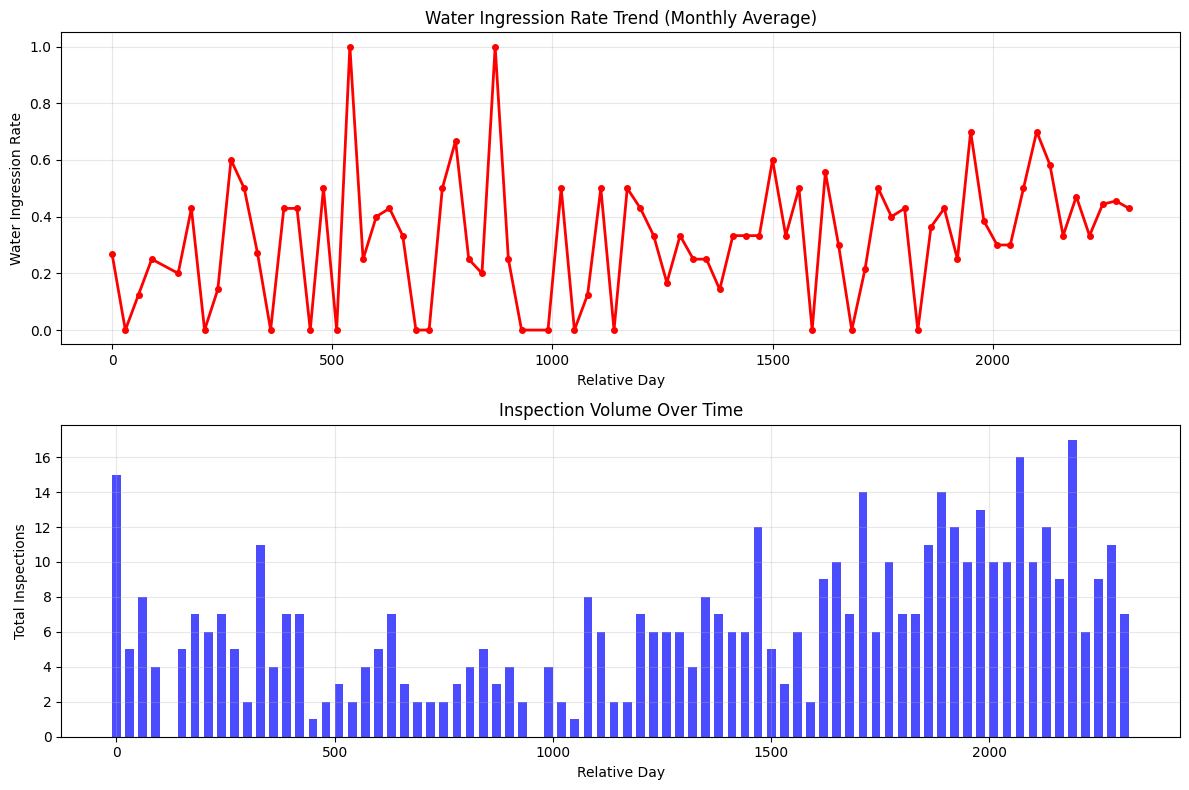

In [14]:
## Time Series Trend Analysis
# Monthly trend analysis
df_time = df.copy().sort_values('Relative Day')
df_time['Month_Period'] = df_time['Relative Day'] // 30
monthly_metrics = df_time.groupby('Month_Period').agg({'Water': ['count', 'sum', 'mean'], 'Relative Day': ['min', 'max']}).round(3)
monthly_metrics.columns = ['Total_Inspections', 'Water_Cases', 'Water_Rate', 'Period_Start', 'Period_End']

# Trend insights
early_period = monthly_metrics.head(12)['Water_Rate'].mean()
recent_period = monthly_metrics.tail(12)['Water_Rate'].mean()
trend_direction = "INCREASING" if recent_period > early_period else "STABLE/DECREASING"
print(f"Early period water rate (first 12 months): {early_period:.3f}")
print(f"Recent period water rate (last 12 months): {recent_period:.3f}")
print(f"Overall trend: {trend_direction}")

# Plot water rate and inspection volume
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Water rate
ax1.plot(monthly_metrics.index * 30, monthly_metrics['Water_Rate'], marker='o', linewidth=2, markersize=4, color='red')
ax1.set_xlabel('Relative Day')
ax1.set_ylabel('Water Ingression Rate')
ax1.set_title('Water Ingression Rate Trend (Monthly Average)')
ax1.grid(True, alpha=0.3)

# Inspection volume
ax2.bar(monthly_metrics.index * 30, monthly_metrics['Total_Inspections'], alpha=0.7, width=20, color='blue')
ax2.set_xlabel('Relative Day')
ax2.set_ylabel('Total Inspections')
ax2.set_title('Inspection Volume Over Time')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [15]:
## Operational Timeline Analysis
# 6-month periods analysis
timeline_analysis = df.groupby(df['Relative Day'] // 180).agg({
    'Water': ['count', 'sum', 'mean'],
    'Relative Day': ['min', 'max'],
    'PN': lambda x: len(x.unique())
}).round(3)

timeline_analysis.columns = ['Total_Inspections', 'Water_Cases', 'Water_Rate', 'Period_Start', 'Period_End', 'Unique_PNs']
timeline_analysis['Period_Label'] = timeline_analysis['Period_Start'].apply(lambda x: f"Days {int(x)}-{int(x)+180}")

print("6-Month Period Analysis:")
display_cols = ['Period_Label', 'Total_Inspections', 'Water_Rate', 'Unique_PNs']
print(timeline_analysis[display_cols].to_string())

# Identify significant events
low_volume = timeline_analysis[timeline_analysis['Total_Inspections'] < 20]
high_water = timeline_analysis[timeline_analysis['Water_Rate'] > 0.5]

if len(low_volume) > 0:
    print(f"\nLow Volume Periods:")
    print(low_volume[['Period_Label', 'Total_Inspections', 'Water_Rate']].to_string())

if len(high_water) > 0:
    print(f"\nHigh Water Rate Periods:")
    print(high_water[['Period_Label', 'Total_Inspections', 'Water_Rate']].to_string())

6-Month Period Analysis:
                Period_Label  Total_Inspections  Water_Rate  Unique_PNs
Relative Day                                                           
0                 Days 0-180                 37       0.189           8
1               Days 182-362                 38       0.289           9
2               Days 367-547                 24       0.292           7
3               Days 549-729                 23       0.391           6
4               Days 720-900                 19       0.421           8
5              Days 907-1087                 13       0.154           4
6             Days 1084-1264                 31       0.323           9
7             Days 1265-1445                 37       0.243           8
8             Days 1442-1622                 34       0.382           8
9             Days 1620-1800                 56       0.321          10
10            Days 1805-1985                 61       0.377          10
11            Days 1980-2160           

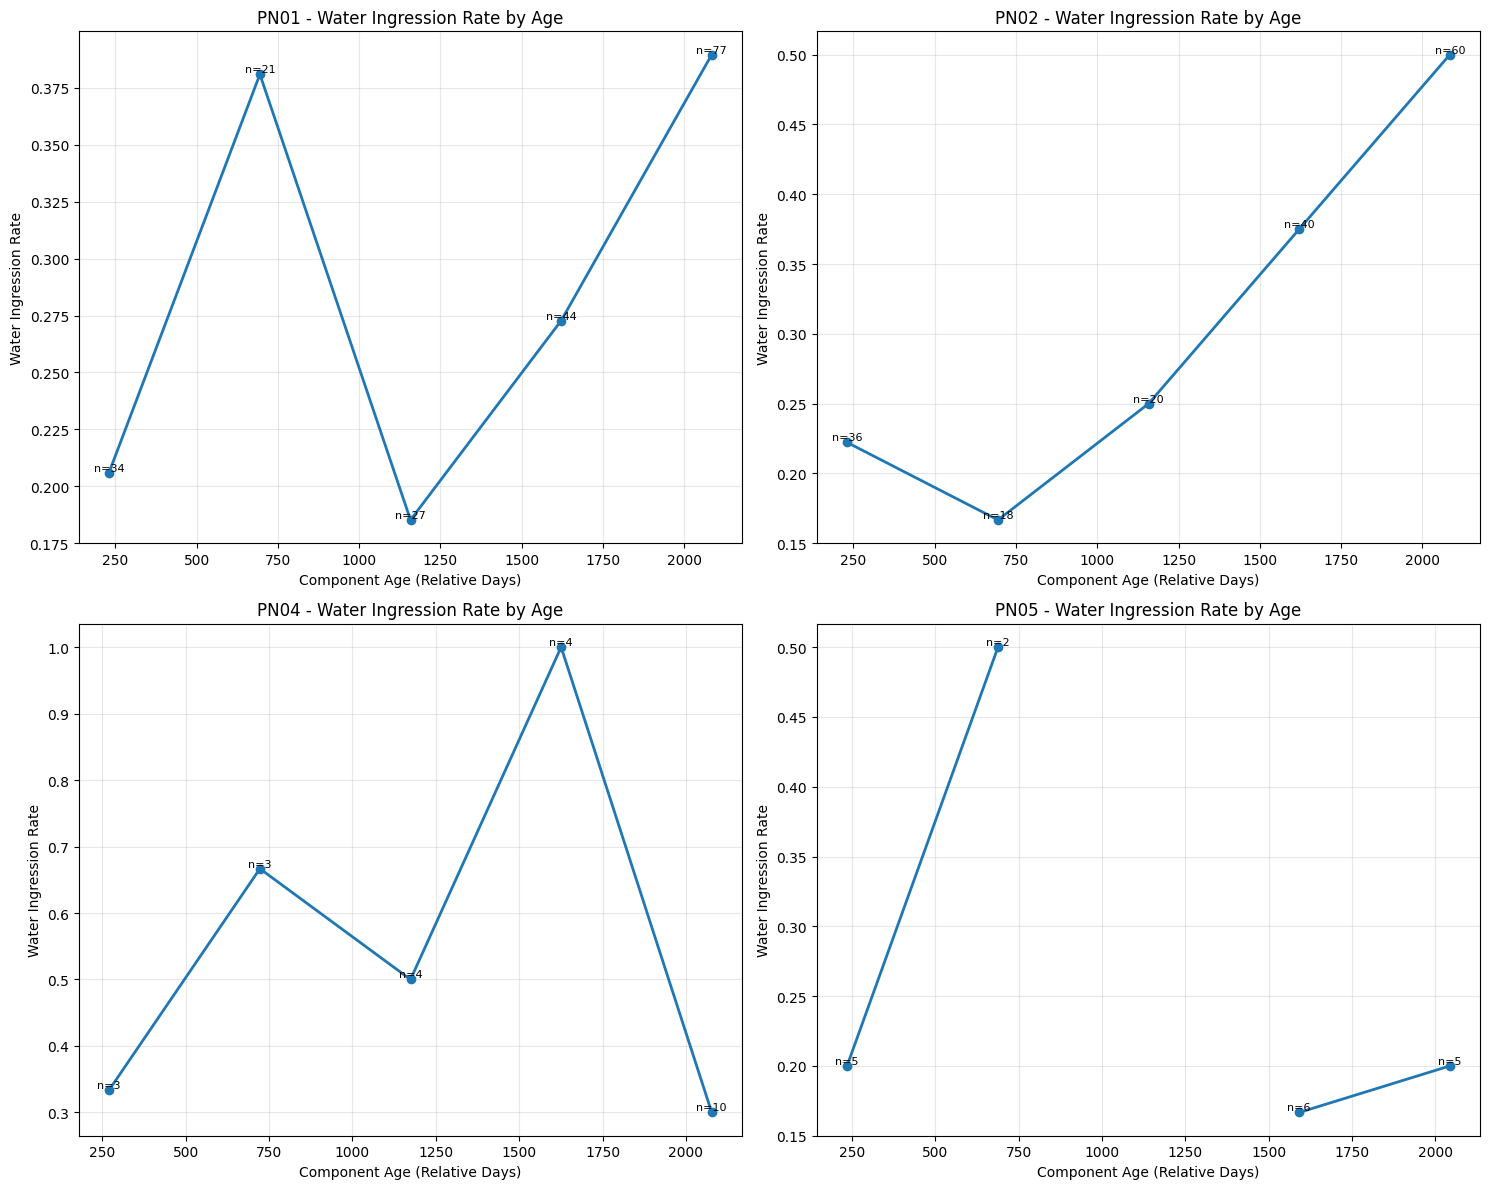

In [16]:
## Component Failure Rate Analysis
# Calculate failure rates by age for each PN
def analyze_failure_by_age():
    top_pns = df['PN'].value_counts().head(4).index
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, pn in enumerate(top_pns):
        pn_data = df[df['PN'] == pn].copy()
        
        # Create age groups
        pn_data['Age_Group'] = pd.cut(pn_data['Relative Day'], bins=5)
        age_analysis = pn_data.groupby('Age_Group').agg({
            'Water': ['count', 'sum', 'mean']
        }).reset_index()
        
        age_analysis.columns = ['Age_Group', 'Count', 'Water_Cases', 'Water_Rate']
        age_analysis['Age_Midpoint'] = age_analysis['Age_Group'].apply(lambda x: x.mid)
        
        # Plot
        axes[i].plot(age_analysis['Age_Midpoint'], age_analysis['Water_Rate'], marker='o', linewidth=2, markersize=6)
        axes[i].set_title(f'{pn} - Water Ingression Rate by Age')
        axes[i].set_xlabel('Component Age (Relative Days)')
        axes[i].set_ylabel('Water Ingression Rate')
        axes[i].grid(True, alpha=0.3)
        
        # Add sample size annotations
        for _, row in age_analysis.iterrows():
            if row['Count'] > 0:
                axes[i].text(row['Age_Midpoint'], row['Water_Rate'], f'n={int(row["Count"])}', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

analyze_failure_by_age()

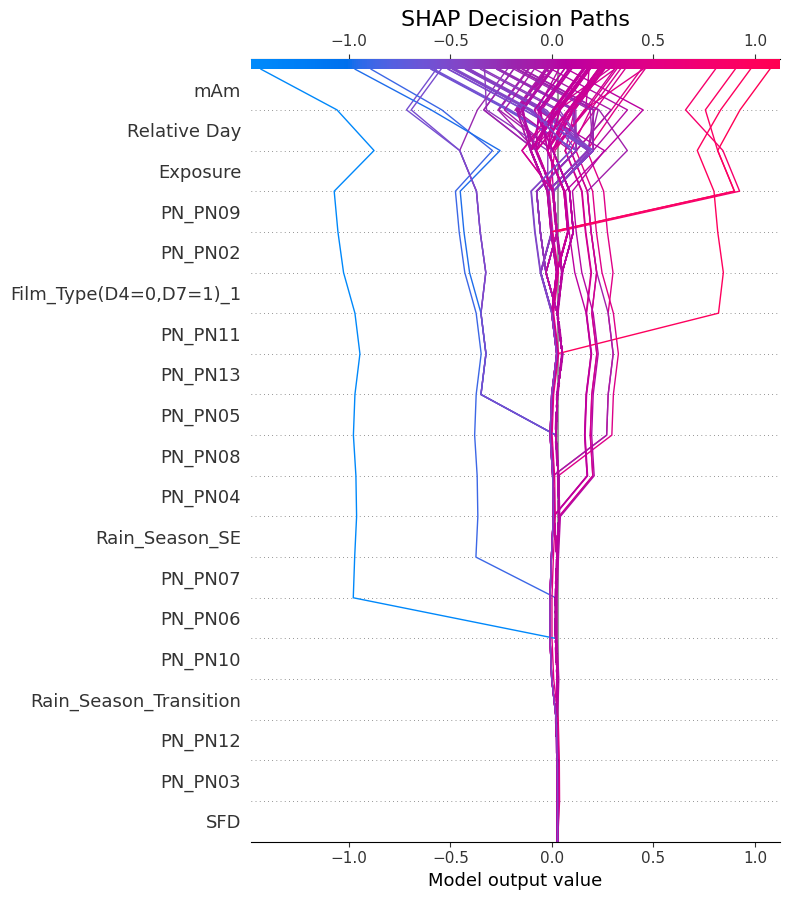

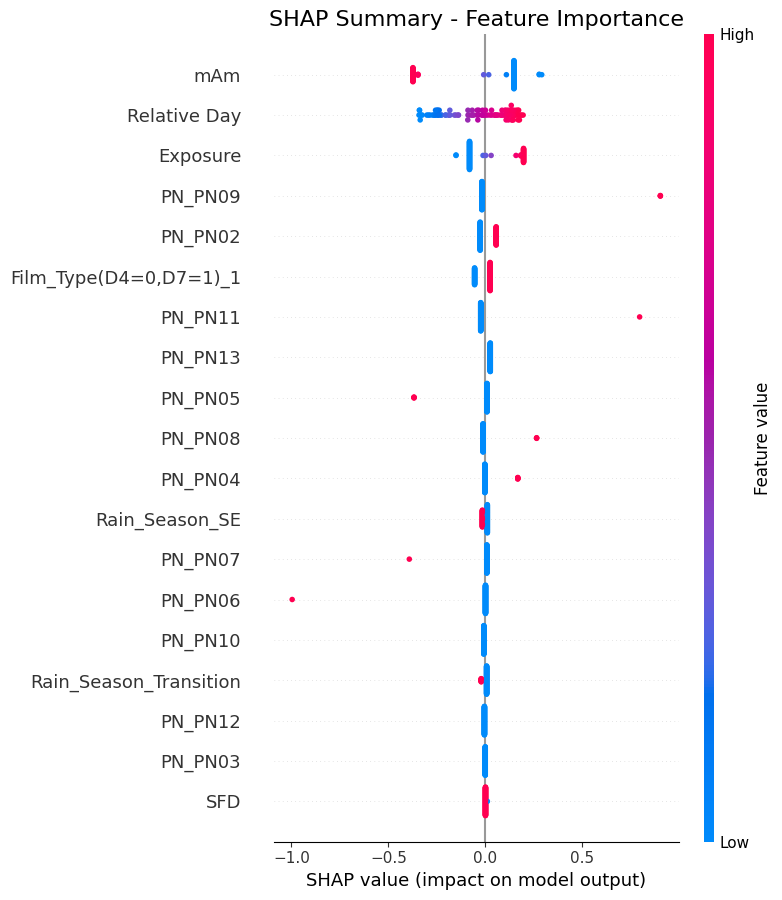

In [17]:
## SHAP Interpretability Analysis
# SHAP for Final Model
X_train_sample = X_train_smote
explainer = shap.Explainer(logreg_smote, X_train_sample)
X_test_sample = X_test
shap_values = explainer(X_test_sample)

# SHAP Decision Plot
plt.figure(figsize=(12, 10))
shap.decision_plot(explainer.expected_value, shap_values.values, feature_names = feature_names, show = False, highlight = 10) # Specific highlight
plt.title('SHAP Decision Paths', fontsize = 16)
plt.tight_layout()
plt.show()

# SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values.values, X_test_sample, feature_names= feature_names,show = False,)
plt.title('SHAP Summary - Feature Importance', fontsize=16)
plt.tight_layout()
plt.show()